In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette
# print(palette.as_hex())

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [3]:
palette2 = sns.color_palette('rocket', n_colors=3)
palette2
# print(palette2.as_hex())

[(0.38092887, 0.12061482, 0.32506528),
 (0.7965014, 0.10506637, 0.31063031),
 (0.95922872, 0.53307513, 0.3748895)]

In [4]:
palette3 = sns.color_palette('deep', n_colors=8)
palette3

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

In [5]:
def modelLV(Y, t, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):
    X1, X2, X3 = Y
    
    dX1 = a0*X1 - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

In [6]:
parNames=['$a_0$', '$a_1$', '$a_2$', '$a_3$', '$a_4$', '$a_5$', '$a_6$', '$a_7$', '$a_8$', '$a_9$', 'RSS']

In [7]:
def simulations(dfParams, Y0, t):
    X1 = []
    X2 = []
    X3 = []
    
    for i in range(dfParams.shape[0]):
        a0 = dfParams['$a_0$'][i]
        a1 = dfParams['$a_1$'][i]
        a2 = dfParams['$a_2$'][i]
        a3 = dfParams['$a_3$'][i]
        a4 = dfParams['$a_4$'][i]
        a5 = dfParams['$a_5$'][i]
        a6 = dfParams['$a_6$'][i]
        a7 = dfParams['$a_7$'][i]
        a8 = dfParams['$a_8$'][i]
        a9 = dfParams['$a_9$'][i]
    
        sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
        X1.append(sol[:,0])
        X2.append(sol[:,1])
        X3.append(sol[:,2])

    return [X1, X2, X3]

In [8]:
def addNoise(df, std=0.05, samples=5):
    # Repeat each row 'samples' times
    df_expanded = df.loc[df.index.repeat(samples)].reset_index(drop=True)

    # Apply log-normal transformation
    # for col in ['X1', 'X2', 'X3']:
    for col in ['X3']:
        df_expanded[col] = np.random.lognormal(np.log(df_expanded[col]), std)

    return df_expanded

# Lotka-Volterra (Cycle model)

\begin{align}
\dot X_1 &= - a_1 X_1 - a_2 X_1 X_2 + a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= -a_7 X_1 X_3 + a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [9]:
a0 = 0.0 # Reproduction rate of X1
a1 = 0.18 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.15 # Reproduction rate of X1 in presence of X3
a4 = 0.11 # Reproduction rate of X2 in presence of X1
a5 = 0.02 # Mortality rate of X2
a6 = 0.12 # Rate of predation of X3 on X2
a7 = 0.04 # Rate of predation of X1 on X3
a8 = 0.12 # Reproduction rate of X3 in presence of X2
a9 = 0.02 # Mortality rate of X3

In [10]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = parNames[:-1]

In [11]:
dfGroundPars

,$a_0$,$a_1$,$a_2$,$a_3$,$a_4$,$a_5$,$a_6$,$a_7$,$a_8$,$a_9$
0,0.0,0.18,0.16,0.15,0.11,0.02,0.12,0.04,0.12,0.02


## Generating data

In [12]:
a0 = dfGroundPars['$a_0$'][0]
a1 = dfGroundPars['$a_1$'][0]
a2 = dfGroundPars['$a_2$'][0]
a3 = dfGroundPars['$a_3$'][0]
a4 = dfGroundPars['$a_4$'][0]
a5 = dfGroundPars['$a_5$'][0]
a6 = dfGroundPars['$a_6$'][0]
a7 = dfGroundPars['$a_7$'][0]
a8 = dfGroundPars['$a_8$'][0]
a9 = dfGroundPars['$a_9$'][0]

In [13]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

In [14]:
# dfData_noise.to_csv('cycle/LVdata_noise.data', sep=' ', index=False, float_format='%.2f')
dfData = pd.read_csv('cycle/LVdata_noise.csv')

In [15]:
# dfData_1 = pd.DataFrame(np.transpose([t[5:80:15],X3_g[5:80:15]]), columns=['Time','X3'])
# dfData_2 = pd.DataFrame(np.transpose([t[15:100:20],X3_g[15:100:20]]), columns=['Time','X3'])
# dfData_3 = pd.DataFrame(np.transpose([t[0:100:10],X3_g[0:100:10]]), columns=['Time','X3'])
# dfData_4 = pd.DataFrame(np.transpose([t[20::40],X3_g[20::40]]), columns=['Time','X3'])

dfNoise_1 = pd.read_csv('cycle/LVdata_X3noise_1.csv')
dfNoise_2 = pd.read_csv('cycle/LVdata_X3noise_2.csv')
dfNoise_3 = pd.read_csv('cycle/LVdata_X3noise_3.csv')
dfNoise_4 = pd.read_csv('cycle/LVdata_X3noise_4.csv')

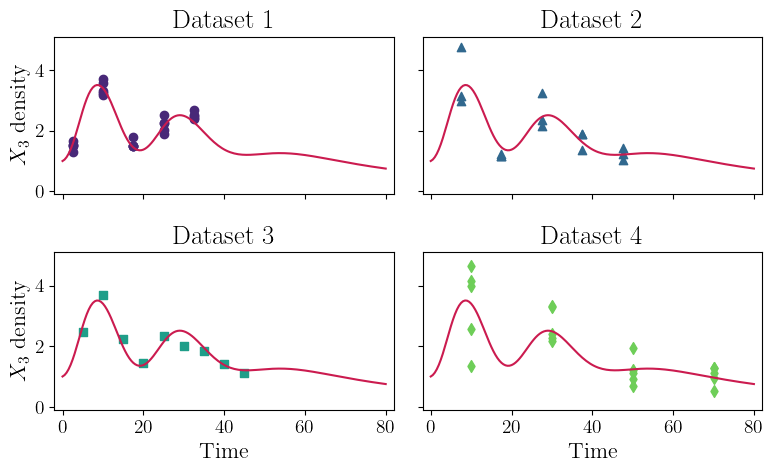

In [16]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,5), sharex=True, sharey=True)

axs[0,0].scatter(x=dfNoise_1['Time'], y=dfNoise_1['X3'], color=palette[0], marker="o", label='Dataset 1')
axs[0,1].scatter(x=dfNoise_2['Time'], y=dfNoise_2['X3'], color=palette[2], marker="^", label='Dataset 2')
axs[1,0].scatter(x=dfNoise_3['Time'], y=dfNoise_3['X3'], color=palette[4], marker="s", label='Dataset 3')
axs[1,1].scatter(x=dfNoise_4['Time'], y=dfNoise_4['X3'], color=palette[6], marker="d", label='Dataset 4')

axs[0,0].plot(t, X3_g, lw=1.5, color=palette2[1])
axs[0,1].plot(t, X3_g, lw=1.5, color=palette2[1])
axs[1,0].plot(t, X3_g, lw=1.5, color=palette2[1])
axs[1,1].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[0,0].set_ylabel('$X_3$ density')
axs[1,0].set_ylabel('$X_3$ density')

axs[1,0].set_xlabel('Time')
axs[1,1].set_xlabel('Time')

for i in range(2):
    for j in range(2):
        axs[i,j].set_title(f'Dataset {2*i + j + 1}')
        axs[i,j].set_ylim((-0.1,5.1))
        # axs[i,j].legend()

plt.setp(axs, xlim=(-2,82))
plt.tight_layout()

# plt.savefig("datasets_X3.svg", transparent=True)
# plt.savefig("datasets_X3.pdf")

plt.show()

## Building qualitative windows
### Normalizing

In [17]:
# Apply Min-Max normalization
minVal = dfNoise_1['X3'].min()
maxVal = dfNoise_1['X3'].max()
dfNoise_1['X3_norm'] = (dfNoise_1['X3'] - minVal) / (maxVal - minVal)

minVal = dfNoise_2['X3'].min()
maxVal = dfNoise_2['X3'].max()
dfNoise_2['X3_norm'] = (dfNoise_2['X3'] - minVal) / (maxVal - minVal)

minVal = dfNoise_3['X3'].min()
maxVal = dfNoise_3['X3'].max()
dfNoise_3['X3_norm'] = (dfNoise_3['X3'] - minVal) / (maxVal - minVal)

minVal = dfNoise_4['X3'].min()
maxVal = dfNoise_4['X3'].max()
dfNoise_4['X3_norm'] = (dfNoise_4['X3'] - minVal) / (maxVal - minVal)

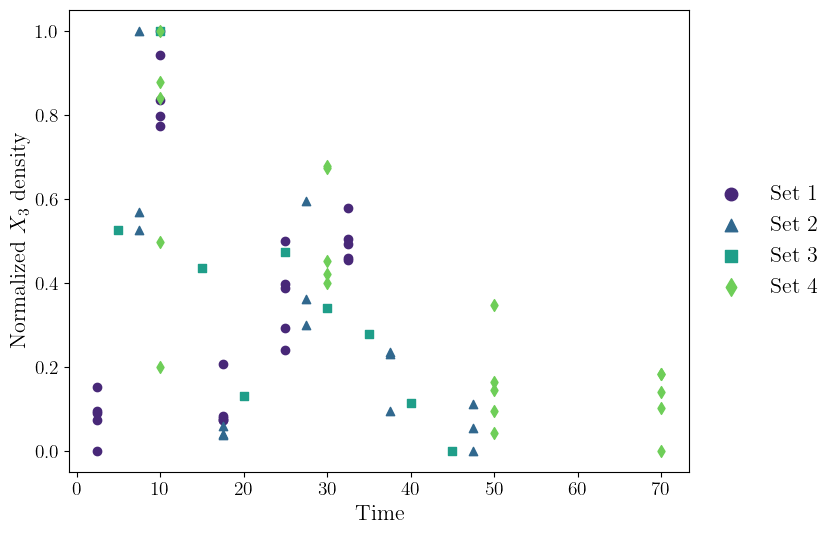

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.scatter(dfNoise_1['Time'], dfNoise_1['X3_norm'],
            color=palette[0], label='Set 1', marker='o')
axs.scatter(dfNoise_2['Time'], dfNoise_2['X3_norm'],
            color=palette[2], label='Set 2', marker='^')
axs.scatter(dfNoise_3['Time'], dfNoise_3['X3_norm'],
            color=palette[4], label='Set 3', marker='s')
axs.scatter(dfNoise_4['Time'], dfNoise_4['X3_norm'],
            color=palette[6], label='Set 4', marker='d')

axs.set_xlabel('Time')
axs.set_ylabel('Normalized $X_3$ density')
axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), markerscale=1.5, frameon=False)

plt.show()

In [19]:
dfNoiseX3 = pd.concat([dfNoise_1[['Time', 'X3_norm']], dfNoise_2[['Time', 'X3_norm']],
                        dfNoise_3[['Time', 'X3_norm']], dfNoise_4[['Time', 'X3_norm']]])
dfNoiseX3 = dfNoiseX3.sort_values(by='Time').reset_index(drop=True)

### Clustering
#### Time

In [20]:
# Elbow Method to determine the optimal number of clusters for Time
inertia = []
k_range = range(1, 11)  # Test for k from 1 to 10

Xdata = dfNoiseX3[['Time']].values

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(Xdata)
    inertia.append(kmeans.inertia_)

diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmin(diff_r) + 1]

In [21]:
inertia_time = inertia
optK_time = optimal_k
# optK_time = 6

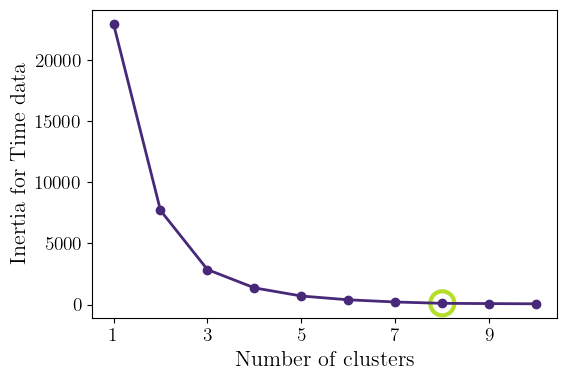

In [22]:
# Plot the elbow method
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia_time, marker='o', color=palette[0], lw = 2)
plt.scatter(optK_time, inertia_time[optK_time - 1],
            s=300, facecolors='none', edgecolors=palette[7], lw = 3)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia for Time data')
plt.xticks([1,3,5,7,9])

plt.show()

In [23]:
kmeans = KMeans(n_clusters=optK_time, n_init=10)
kmeans.fit(Xdata)
dfNoiseX3['Time labels'] = kmeans.labels_

#### X3

In [24]:
# Elbow Method to determine the optimal number of clusters for X3
inertia = []
k_range = range(1, 11)  # Test for k from 1 to 10

Xdata = dfNoiseX3[['X3_norm']].values

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(Xdata)
    inertia.append(kmeans.inertia_)

diff = np.diff(inertia)
diff_r = diff[1:] / diff[:-1]
optimal_k = k_range[np.argmin(diff_r) + 1]

In [25]:
inertia_X3 = inertia
optK_X3 = optimal_k
# optK_X3 = 3

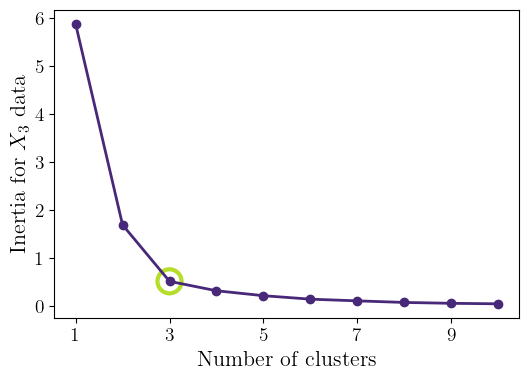

In [26]:
# Plot the elbow method
plt.figure(figsize=(6, 4))
plt.plot(k_range, inertia_X3, marker='o', color=palette[0], lw = 2)
plt.scatter(optK_X3, inertia_X3[optK_X3 - 1],
            s=300, facecolors='none', edgecolors=palette[7], lw = 3)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia for $X_3$ data')
plt.xticks([1,3,5,7,9])

plt.show()

In [27]:
kmeans = KMeans(n_clusters=optK_X3, n_init=10)
kmeans.fit(Xdata)
dfNoiseX3['X3 labels'] = kmeans.labels_

### Mesh: defining qualitative windows

In [28]:
# Getting the mesh
xMin = []
xMax = []
unique_time_labels = sorted(dfNoiseX3['Time labels'].unique())
for label in unique_time_labels:
    x = dfNoiseX3[dfNoiseX3['Time labels'] == label]['Time']
    xMin.append(x.min())
    xMax.append(x.max())
xMin.sort()
xMax.sort()

xCell = [xMin[0]]
for i in range(len(xMin)-1):
    xCell.append((xMax[i]+xMin[i+1])/2)
xCell.append(xMax[-1] + xMin[-1] - xCell[-1])

# Adding horizontal lines for CD8 labels
yMin = []
yMax = []
unique_x3_labels = sorted(dfNoiseX3['X3 labels'].unique())
for label in unique_x3_labels:
    y = dfNoiseX3[dfNoiseX3['X3 labels'] == label]['X3_norm']
    yMin.append(y.min())
    yMax.append(y.max())
yMin.sort()
yMax.sort()

yCell = [yMin[0]]
for i in range(len(yMin)-1):
    yCell.append((yMax[i]+yMin[i+1])/2)
yCell.append(yMax[-1])

In [29]:
# Use numpy histogram2d to count occurrences in each cell
cellCounts, _, _ = np.histogram2d(dfNoiseX3['Time'], dfNoiseX3['X3_norm'], bins=[xCell, yCell])

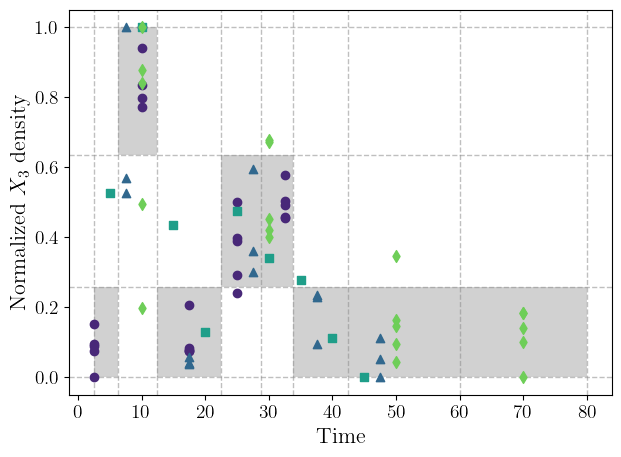

In [30]:
# Plotting the mesh
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,5), facecolor='white')

axs.scatter(dfNoise_1['Time'], dfNoise_1['X3_norm'],
            color=palette[0], label='Dataset 1', marker='o')
axs.scatter(dfNoise_2['Time'], dfNoise_2['X3_norm'],
            color=palette[2], label='Dataset 2', marker='^')
axs.scatter(dfNoise_3['Time'], dfNoise_3['X3_norm'],
            color=palette[4], label='Dataset 3', marker='s')
axs.scatter(dfNoise_4['Time'], dfNoise_4['X3_norm'],
            color=palette[6], label='Dataset 4', marker='d')

# Adding vertical lines for Time labels
for i in range(len(xCell)):
    axs.axvline(x=xCell[i], color=palette3[7], linestyle='--', alpha = 0.55, zorder=0, lw=1)

# Adding horizontal lines for X3 labels
for i in range(len(yCell)):
    axs.axhline(y=yCell[i], color=palette3[7], linestyle='--', alpha = 0.55, zorder=0, lw=1)

# Add squares (qualitative windows)
qualWin = []
xDiff = np.diff(xCell)
yDiff = np.diff(yCell)
for i in range(cellCounts.shape[0]):
    j = cellCounts[i].argmax()
    rect = plt.Rectangle((xCell[i], yCell[j]), xDiff[i], yDiff[j], fc=palette3[7], alpha = 0.4, zorder=-1)
    axs.add_patch(rect)
    qualWin.append([xCell[i], xCell[i+1], yCell[j], yCell[j+1]])

axs.set_xlabel('Time')
axs.set_ylabel('Normalized $X_3$ density')
# axs.legend(loc='center', bbox_to_anchor=(0.5, 1.02), ncol=2, markerscale=1.5, frameon=False)
# plt.savefig('windows_X3.pdf', bbox_inches='tight')
# plt.savefig('windows_X3.svg', transparent=True)

plt.show()

In [31]:
dfQualWin = pd.DataFrame(qualWin, columns=['Tmin', 'Tmax', 'X3min', 'X3max'])
dfQualWin

,Tmin,Tmax,X3min,X3max
0,2.50,6.25,0.000000,0.259050
1,6.25,12.50,0.634149,1.000000
2,12.50,22.50,0.000000,0.259050
3,22.50,28.75,0.259050,0.634149
4,28.75,33.75,0.259050,0.634149
5,33.75,42.50,0.000000,0.259050
6,42.50,60.00,0.000000,0.259050
7,60.00,80.00,0.000000,0.259050


### Plotting wiondows with the ground truth

In [32]:
# We need to rescale the windows to the original X3 scale
# X3_0 = X3_g.min()
X3_0 = 1
scale = X3_g.max() - X3_0
ref = X3_0 - 0.05*scale # We start 5% before the minimum
dfQualWin['X3min'] = 1.1*scale*dfQualWin['X3min'] + ref # Finish 5% after the maximum
dfQualWin['X3max'] = 1.1*scale*dfQualWin['X3max'] + ref # Finish 5% after the maximum

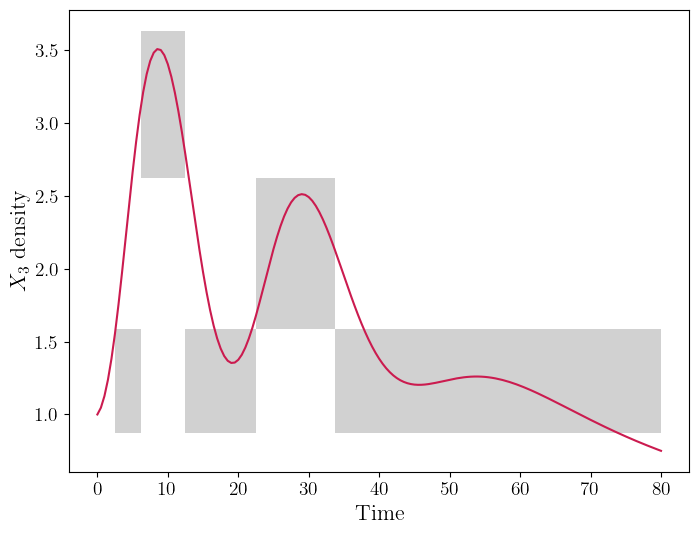

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X3_g, lw=1.5, color=palette2[1])

# Add squares (qualitative windows)
Tmin = dfQualWin['Tmin']
Tdiff = dfQualWin['Tmax'] - dfQualWin['Tmin']

X3min = dfQualWin['X3min']
X3diff = dfQualWin['X3max'] - dfQualWin['X3min']

for a, b, w, h in zip(Tmin, X3min, Tdiff, X3diff):
    rect = plt.Rectangle((a, b), w, h, fc=palette3[7], alpha = 0.4, zorder=-1)
    axs.add_patch(rect)

axs.set_xlabel('Time')
axs.set_ylabel('$X_3$ density')
# plt.savefig('windows_X3.pdf', bbox_inches='tight')

plt.show()

## Recovering parameters

In [34]:
dfParams_ground = dfGroundPars.drop(columns=['$a_0$']).melt(var_name='Parameters', value_name='Values')

In [35]:
dfData = pd.read_csv('cycle/LVdata_noise.csv')

### Quantitative X1

In [36]:
dfParams = pd.read_csv('cycle/bestPars_qt.dat', sep=' ', names=parNames)

In [37]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1_I, X2_I, X3_I = simulations(dfParams, Y0, t)

In [38]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
X1_2D = np.array(X1_I)
X2_2D = np.array(X2_I)
X3_2D = np.array(X3_I)

median_X1_I = np.median(X1_2D, axis=0)
confidence_X1_I = np.percentile(X1_2D, [2.5, 97.5], axis=0)

median_X2_I = np.median(X2_2D, axis=0)
confidence_X2_I = np.percentile(X2_2D, [2.5, 97.5], axis=0)

median_X3_I = np.median(X3_2D, axis=0)
confidence_X3_I = np.percentile(X3_2D, [2.5, 97.5], axis=0)

In [39]:
dfParams_qt = dfParams.drop(columns=['$a_0$', 'RSS']).melt(var_name='Parameters', value_name='Values')

#### Likelihood profiles

In [40]:
df_a1 = pd.read_csv('cycle/profilesData/a1Profile.dat', sep=' ', names=parNames).filter(['$a_1$', 'RSS'])
df_a2 = pd.read_csv('cycle/profilesData/a2Profile.dat', sep=' ', names=parNames).filter(['$a_2$', 'RSS'])
df_a3 = pd.read_csv('cycle/profilesData/a3Profile.dat', sep=' ', names=parNames).filter(['$a_3$', 'RSS'])
df_a4 = pd.read_csv('cycle/profilesData/a4Profile.dat', sep=' ', names=parNames).filter(['$a_4$', 'RSS'])
df_a5 = pd.read_csv('cycle/profilesData/a5Profile.dat', sep=' ', names=parNames).filter(['$a_5$', 'RSS'])
df_a6 = pd.read_csv('cycle/profilesData/a6Profile.dat', sep=' ', names=parNames).filter(['$a_6$', 'RSS'])
df_a7 = pd.read_csv('cycle/profilesData/a7Profile.dat', sep=' ', names=parNames).filter(['$a_7$', 'RSS'])
df_a8 = pd.read_csv('cycle/profilesData/a8Profile.dat', sep=' ', names=parNames).filter(['$a_8$', 'RSS'])
df_a9 = pd.read_csv('cycle/profilesData/a9Profile.dat', sep=' ', names=parNames).filter(['$a_9$', 'RSS'])

In [41]:
df_a1_qt = df_a1
df_a2_qt = df_a2
df_a3_qt = df_a3
df_a4_qt = df_a4
df_a5_qt = df_a5
df_a6_qt = df_a6
df_a7_qt = df_a7
df_a8_qt = df_a8
df_a9_qt = df_a9

### Quantitative X1 and X3

In [42]:
dfParams = pd.read_csv('cycle/bestPars_qt_X3.dat', sep=' ', names=parNames)

In [43]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1_II, X2_II, X3_II = simulations(dfParams, Y0, t)

/tmp/ipykernel_457907/201619411.py:18: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))


In [44]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
X1_2D = np.array(X1_II)
X2_2D = np.array(X2_II)
X3_2D = np.array(X3_II)

median_X1_II = np.median(X1_2D, axis=0)
confidence_X1_II = np.percentile(X1_2D, [2.5, 97.5], axis=0)

median_X2_II = np.median(X2_2D, axis=0)
confidence_X2_II = np.percentile(X2_2D, [2.5, 97.5], axis=0)

median_X3_II = np.median(X3_2D, axis=0)
confidence_X3_II = np.percentile(X3_2D, [2.5, 97.5], axis=0)

In [45]:
dfParams_qt_X3 = dfParams.drop(columns=['$a_0$', 'RSS']).melt(var_name='Parameters', value_name='Values')

#### Likelihood profiles

In [46]:
df_a1 = pd.read_csv('cycle/profilesData/a1Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_1$', 'RSS'])
df_a2 = pd.read_csv('cycle/profilesData/a2Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_2$', 'RSS'])
df_a3 = pd.read_csv('cycle/profilesData/a3Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_3$', 'RSS'])
df_a4 = pd.read_csv('cycle/profilesData/a4Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_4$', 'RSS'])
df_a5 = pd.read_csv('cycle/profilesData/a5Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_5$', 'RSS'])
df_a6 = pd.read_csv('cycle/profilesData/a6Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_6$', 'RSS'])
df_a7 = pd.read_csv('cycle/profilesData/a7Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_7$', 'RSS'])
df_a8 = pd.read_csv('cycle/profilesData/a8Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_8$', 'RSS'])
df_a9 = pd.read_csv('cycle/profilesData/a9Profile_qt_X3.dat', sep=' ', names=parNames).filter(['$a_9$', 'RSS'])

In [47]:
df_a1_qt_X3 = df_a1
df_a2_qt_X3 = df_a2
df_a3_qt_X3 = df_a3
df_a4_qt_X3 = df_a4
df_a5_qt_X3 = df_a5
df_a6_qt_X3 = df_a6
df_a7_qt_X3 = df_a7
df_a8_qt_X3 = df_a8
df_a9_qt_X3 = df_a9

### Quantitative X1 and Qualitative X3

In [48]:
dfQual_X3 = pd.read_csv('cycle/qualX3cell.csv')

In [49]:
dfParams = pd.read_csv('cycle/bestPars_ql_X3.dat', sep=' ', names=parNames)

In [50]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1_III, X2_III, X3_III = simulations(dfParams, Y0, t)

In [51]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
X1_2D = np.array(X1_III)
X2_2D = np.array(X2_III)
X3_2D = np.array(X3_III)

median_X1_III = np.median(X1_2D, axis=0)
confidence_X1_III = np.percentile(X1_2D, [2.5, 97.5], axis=0)

median_X2_III = np.median(X2_2D, axis=0)
confidence_X2_III = np.percentile(X2_2D, [2.5, 97.5], axis=0)

median_X3_III = np.median(X3_2D, axis=0)
confidence_X3_III = np.percentile(X3_2D, [2.5, 97.5], axis=0)

In [52]:
dfParams_ql_X3 = dfParams.drop(columns=['$a_0$', 'RSS']).melt(var_name='Parameters', value_name='Values')

#### Likelihood profiles

In [53]:
df_a1 = pd.read_csv('cycle/profilesData/a1Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_1$', 'RSS'])
df_a2 = pd.read_csv('cycle/profilesData/a2Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_2$', 'RSS'])
df_a3 = pd.read_csv('cycle/profilesData/a3Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_3$', 'RSS'])
df_a4 = pd.read_csv('cycle/profilesData/a4Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_4$', 'RSS'])
df_a5 = pd.read_csv('cycle/profilesData/a5Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_5$', 'RSS'])
df_a6 = pd.read_csv('cycle/profilesData/a6Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_6$', 'RSS'])
df_a7 = pd.read_csv('cycle/profilesData/a7Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_7$', 'RSS'])
df_a8 = pd.read_csv('cycle/profilesData/a8Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_8$', 'RSS'])
df_a9 = pd.read_csv('cycle/profilesData/a9Profile_ql_X3.dat', sep=' ', names=parNames).filter(['$a_9$', 'RSS'])

In [54]:
df_a1_ql_X3 = df_a1
df_a2_ql_X3 = df_a2
df_a3_ql_X3 = df_a3
df_a4_ql_X3 = df_a4
df_a5_ql_X3 = df_a5
df_a6_ql_X3 = df_a6
df_a7_ql_X3 = df_a7
df_a8_ql_X3 = df_a8
df_a9_ql_X3 = df_a9

## Comparative

In [55]:
dfQual_X3

,Tmin,Tmax,X3min,X3max
0,0.00,6.25,0.874593,1.609936
1,6.25,12.50,2.624187,3.633557
2,12.50,22.50,0.874593,1.609936
3,22.50,28.75,1.609936,2.624187
4,28.75,33.75,1.609936,2.624187
5,33.75,42.50,0.874593,1.609936
6,42.50,60.00,0.874593,1.609936
7,60.00,80.00,0.874593,1.609936


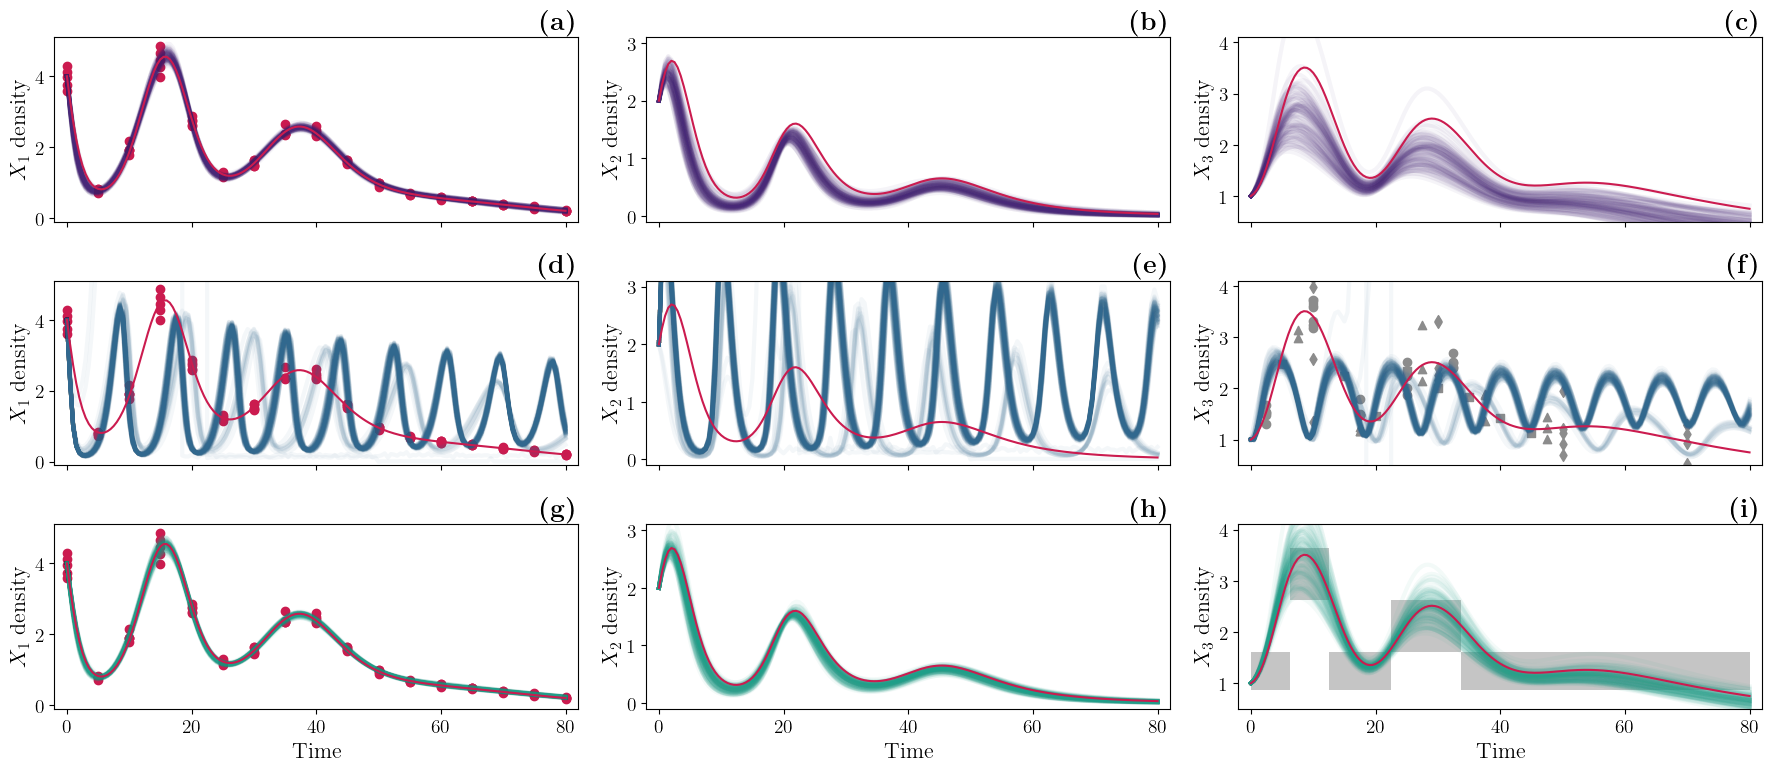

In [56]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(18,8), sharex=True)

# for i in range(dfParams.shape[0]):
for i in range(100):
    axs[0,0].plot(t, X1_I[i], lw=3, color=palette[0], alpha=0.05)
    axs[0,1].plot(t, X2_I[i], lw=3, color=palette[0], alpha=0.05)
    axs[0,2].plot(t, X3_I[i], lw=3, color=palette[0], alpha=0.05)

# for i in range(dfParams.shape[0]):
for i in range(100):
    axs[1,0].plot(t, X1_II[i], lw=3, color=palette[2], alpha=0.05)
    axs[1,1].plot(t, X2_II[i], lw=3, color=palette[2], alpha=0.05)
    axs[1,2].plot(t, X3_II[i], lw=3, color=palette[2], alpha=0.05)

# for i in range(dfParams.shape[0]):
for i in range(100):
    axs[2,0].plot(t, X1_III[i], lw=3, color=palette[4], alpha=0.05)
    axs[2,1].plot(t, X2_III[i], lw=3, color=palette[4], alpha=0.05)
    axs[2,2].plot(t, X3_III[i], lw=3, color=palette[4], alpha=0.05)

axs[0,0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette2[1], marker="o")
axs[1,0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette2[1], marker="o")
axs[2,0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette2[1], marker="o")

axs[1,2].scatter(dfNoise_1['Time'], dfNoise_1['X3'],
                color=palette3[7], label='Set 1', marker='o')
axs[1,2].scatter(dfNoise_2['Time'], dfNoise_2['X3'],
                color=palette3[7], label='Set 2', marker='^')
axs[1,2].scatter(dfNoise_3['Time'], dfNoise_3['X3'],
                color=palette3[7], label='Set 3', marker='s')
axs[1,2].scatter(dfNoise_4['Time'], dfNoise_4['X3'],
                color=palette3[7], label='Set 4', marker='d')

for i in range(len(dfQual_X3['Tmin'])):
    timeWindow = dfQual_X3['Tmax'].values[i] - dfQual_X3['Tmin'].values[i]
    valueWindow = dfQual_X3['X3max'].values[i] - dfQual_X3['X3min'].values[i]
    rect = plt.Rectangle((dfQual_X3['Tmin'].values[i], dfQual_X3['X3min'].values[i]),
                         timeWindow, valueWindow, fc=palette3[7], alpha = 0.5, zorder=-1)
    axs[2,2].add_patch(rect)

axs[0,0].plot(t, X1_g, lw=1.5, color=palette2[1])
axs[0,1].plot(t, X2_g, lw=1.5, color=palette2[1])
axs[0,2].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[1,0].plot(t, X1_g, lw=1.5, color=palette2[1])
axs[1,1].plot(t, X2_g, lw=1.5, color=palette2[1])
axs[1,2].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[2,0].plot(t, X1_g, lw=1.5, color=palette2[1])
axs[2,1].plot(t, X2_g, lw=1.5, color=palette2[1])
axs[2,2].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[0,0].set_ylabel('$X_1$ density')
axs[0,1].set_ylabel('$X_2$ density')
axs[0,2].set_ylabel('$X_3$ density')

axs[1,0].set_ylabel('$X_1$ density')
axs[1,1].set_ylabel('$X_2$ density')
axs[1,2].set_ylabel('$X_3$ density')

axs[2,0].set_ylabel('$X_1$ density')
axs[2,1].set_ylabel('$X_2$ density')
axs[2,2].set_ylabel('$X_3$ density')

axs[2,0].set_xlabel('Time')
axs[2,1].set_xlabel('Time')
axs[2,2].set_xlabel('Time')

axs[0,0].set_title(r'\textbf{(a)}', loc='right')
axs[0,1].set_title(r'\textbf{(b)}', loc='right')
axs[0,2].set_title(r'\textbf{(c)}', loc='right')
axs[1,0].set_title(r'\textbf{(d)}', loc='right')
axs[1,1].set_title(r'\textbf{(e)}', loc='right')
axs[1,2].set_title(r'\textbf{(f)}', loc='right')
axs[2,0].set_title(r'\textbf{(g)}', loc='right')
axs[2,1].set_title(r'\textbf{(h)}', loc='right')
axs[2,2].set_title(r'\textbf{(i)}', loc='right')

for i in range(3):
    axs[i,0].set_ylim((-0.1,5.1))
    axs[i,1].set_ylim((-0.1,3.1))
    axs[i,2].set_ylim((0.5,4.1))

plt.setp(axs, xlim=(-2,82))
plt.tight_layout()

# plt.savefig("cycleLV_graphs_all.svg", transparent=True)

plt.show()

In [57]:
dfParams_qt['Strategy'] = 'I'
dfParams_qt_X3['Strategy'] = 'II'
dfParams_ql_X3['Strategy'] = 'III'

In [58]:
dfParams_all = pd.concat([dfParams_qt, dfParams_qt_X3, dfParams_ql_X3])
# dfParams_all_cycle = dfParams_all.copy()

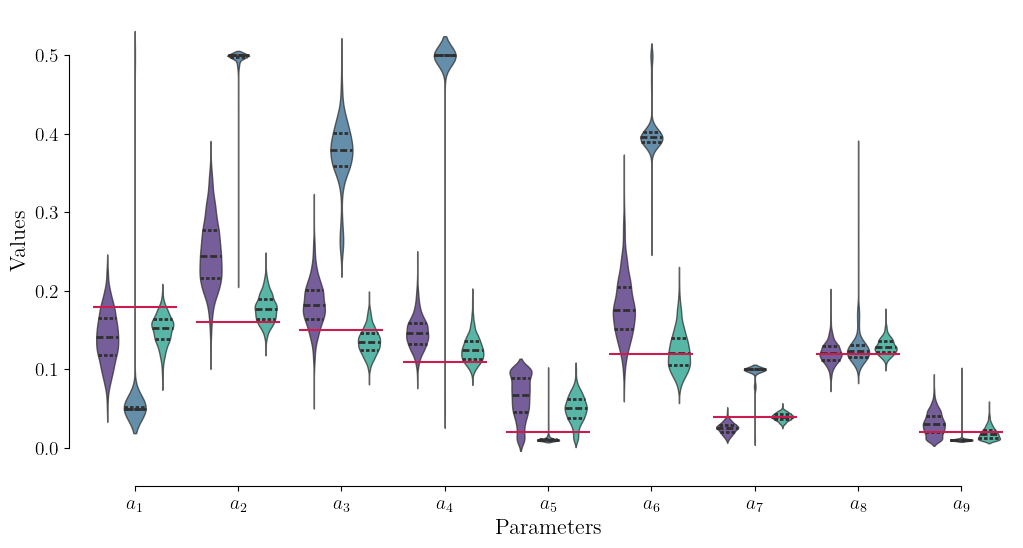

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6), facecolor='white')

colors = [palette[0], palette[2], palette[4]]

axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategy',
               palette=colors, alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color=palette2[1], linestyle="none", marker="_", markersize=60, markeredgewidth=1.5)

sns.despine(offset=10, trim=True);

plt.legend([],[], frameon=False)

# plt.savefig("cycleLV_boots_all.svg", transparent=True)

plt.show()

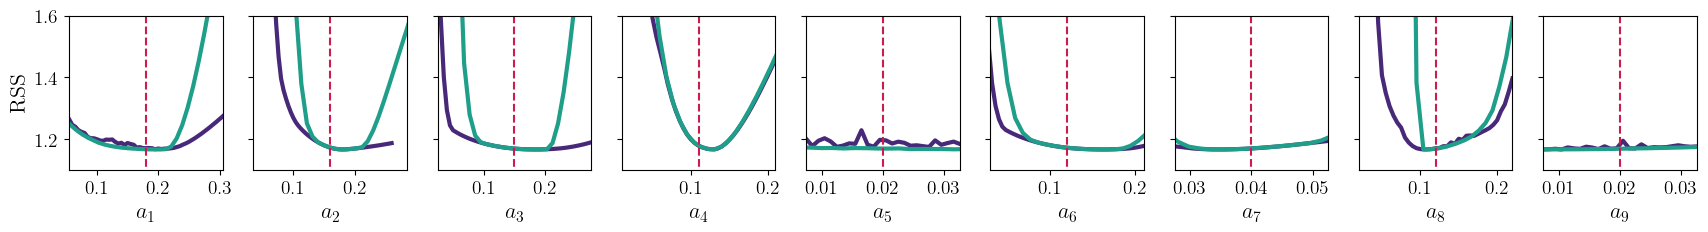

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(21,2), sharey=True, facecolor='white')

axs[0].plot(df_a1_qt['$a_1$'], df_a1_qt['RSS'], lw=3, color=palette[0])
axs[0].plot(df_a1_qt_X3['$a_1$'], df_a1_qt_X3['RSS'], lw=3, color=palette[2])
axs[0].plot(df_a1_ql_X3['$a_1$'], df_a1_ql_X3['RSS'], lw=3, color=palette[4])
axs[0].vlines(dfGroundPars['$a_1$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[0].set_xlabel('$a_1$')
axs[0].set_ylabel('RSS')
axs[0].set_xlim((0.055,0.305))

axs[1].plot(df_a2_qt['$a_2$'], df_a2_qt['RSS'], lw=3, color=palette[0])
axs[1].plot(df_a2_qt_X3['$a_2$'], df_a2_qt_X3['RSS'], lw=3, color=palette[2])
axs[1].plot(df_a2_ql_X3['$a_2$'], df_a2_ql_X3['RSS'], lw=3, color=palette[4])
axs[1].vlines(dfGroundPars['$a_2$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[1].set_xlabel('$a_2$')
axs[1].set_xlim((0.035,0.285))

axs[2].plot(df_a3_qt['$a_3$'], df_a3_qt['RSS'], lw=3, color=palette[0])
axs[2].plot(df_a3_qt_X3['$a_3$'], df_a3_qt_X3['RSS'], lw=3, color=palette[2])
axs[2].plot(df_a3_ql_X3['$a_3$'], df_a3_ql_X3['RSS'], lw=3, color=palette[4])
axs[2].vlines(dfGroundPars['$a_3$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[2].set_xlabel('$a_3$')
axs[2].set_xlim((0.025,0.275))

axs[3].plot(df_a4_qt['$a_4$'], df_a4_qt['RSS'], lw=3, color=palette[0])
axs[3].plot(df_a4_qt_X3['$a_4$'], df_a4_qt_X3['RSS'], lw=3, color=palette[2])
axs[3].plot(df_a4_ql_X3['$a_4$'], df_a4_ql_X3['RSS'], lw=3, color=palette[4])
axs[3].vlines(dfGroundPars['$a_4$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[3].set_xlabel('$a_4$')
axs[3].set_xlim((0.01,0.210))

axs[4].plot(df_a5_qt['$a_5$'], df_a5_qt['RSS'], lw=3, color=palette[0])
axs[4].plot(df_a5_qt_X3['$a_5$'], df_a5_qt_X3['RSS'], lw=3, color=palette[2])
axs[4].plot(df_a5_ql_X3['$a_5$'], df_a5_ql_X3['RSS'], lw=3, color=palette[4])
axs[4].vlines(dfGroundPars['$a_5$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[4].set_xlabel('$a_5$')
axs[4].set_xlim((0.0075,0.0325))

axs[5].plot(df_a6_qt['$a_6$'], df_a6_qt['RSS'], lw=3, color=palette[0])
axs[5].plot(df_a6_qt_X3['$a_6$'], df_a6_qt_X3['RSS'], lw=3, color=palette[2])
axs[5].plot(df_a6_ql_X3['$a_6$'], df_a6_ql_X3['RSS'], lw=3, color=palette[4])
axs[5].vlines(dfGroundPars['$a_6$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[5].set_xlabel('$a_6$')
# axs[5].set_xlim((0.02,0.220))
axs[5].set_xlim((0.03, 0.21))

axs[6].plot(df_a7_qt['$a_7$'], df_a7_qt['RSS'], lw=3, color=palette[0])
axs[6].plot(df_a7_qt_X3['$a_7$'], df_a7_qt_X3['RSS'], lw=3, color=palette[2])
axs[6].plot(df_a7_ql_X3['$a_7$'], df_a7_ql_X3['RSS'], lw=3, color=palette[4])
axs[6].vlines(dfGroundPars['$a_7$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[6].set_xlabel('$a_7$')
axs[6].set_xlim((0.0275,0.0525))

axs[7].plot(df_a8_qt['$a_8$'], df_a8_qt['RSS'], lw=3, color=palette[0])
axs[7].plot(df_a8_qt_X3['$a_8$'], df_a8_qt_X3['RSS'], lw=3, color=palette[2])
axs[7].plot(df_a8_ql_X3['$a_8$'], df_a8_ql_X3['RSS'], lw=3, color=palette[4])
axs[7].vlines(dfGroundPars['$a_8$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[7].set_xlabel('$a_8$')
axs[7].set_xlim((0.02,0.220))

axs[8].plot(df_a9_qt['$a_9$'], df_a9_qt['RSS'], lw=3, color=palette[0])
axs[8].plot(df_a9_qt_X3['$a_9$'], df_a9_qt_X3['RSS'], lw=3, color=palette[2])
axs[8].plot(df_a9_ql_X3['$a_9$'], df_a9_ql_X3['RSS'], lw=3, color=palette[4])
axs[8].vlines(dfGroundPars['$a_9$'], ymin=0.0, ymax=1.7, colors=palette2[1], linestyles='dashed')
axs[8].set_xlabel('$a_9$')
axs[8].set_xlim((0.0075,0.0325))

# plt.setp(axs, ylim=(1.1,200.6))
# plt.setp(axs, ylim=(1.1,10.6))
plt.setp(axs, ylim=(1.1,1.6))

# plt.savefig("cycleLV_like_all.svg", transparent=True)

plt.show()

## Selected graphs

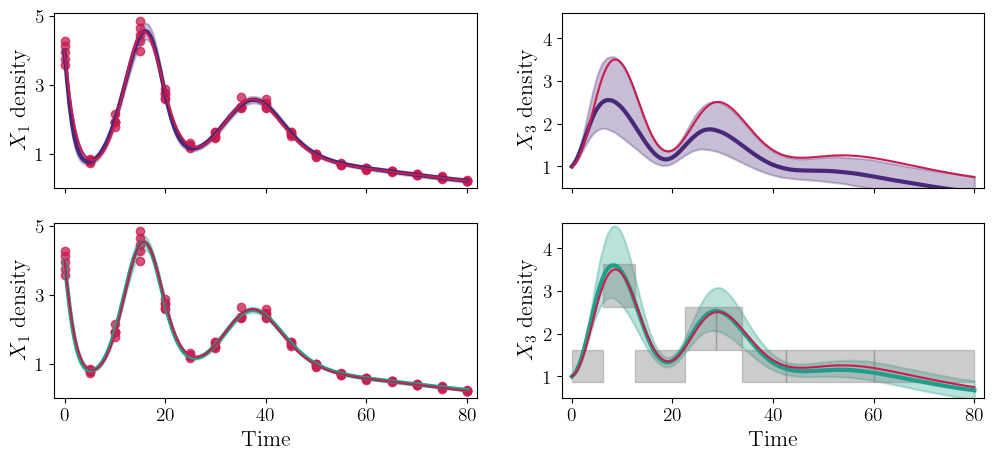

In [66]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)

axs[0,0].plot(t, median_X1_I, lw=3, color=palette[0])
axs[0,0].fill_between(t, confidence_X1_I[0], confidence_X1_I[1], color=palette[0], alpha=0.3, lw=1.5)

axs[0,1].plot(t, median_X3_I, lw=3, color=palette[0])
axs[0,1].fill_between(t, confidence_X3_I[0], confidence_X3_I[1], color=palette[0], alpha=0.3, lw=1.5)

axs[1,0].plot(t, median_X1_III, lw=3, color=palette[4])
axs[1,0].fill_between(t, confidence_X1_III[0], confidence_X1_III[1], color=palette[4], alpha=0.3, lw=1.5)

axs[1,1].plot(t, median_X3_III, lw=3, color=palette[4])
axs[1,1].fill_between(t, confidence_X3_III[0], confidence_X3_III[1], color=palette[4], alpha=0.3, lw=1.5)

axs[0,0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette2[1], marker="o", alpha=0.75)
axs[1,0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette2[1], marker="o", alpha=0.75)

# Overlay window constraints
for _, row in dfQual_X3.iterrows():
    tmin, tmax = row['Tmin'], row['Tmax']
    x3min, x3max = row['X3min'], row['X3max']
    axs[1,1].fill_betweenx(
        [x3min, x3max], tmin, tmax, color='gray', alpha=0.4, label='Window' if _ == 0 else None
    )

# for i in range(len(dfQual_X3['Tmin'])):
#     timeWindow = dfQual_X3['Tmax'].values[i] - dfQual_X3['Tmin'].values[i]
#     valueWindow = dfQual_X3['X3max'].values[i] - dfQual_X3['X3min'].values[i]
#     rect = plt.Rectangle((dfQual_X3['Tmin'].values[i], dfQual_X3['X3min'].values[i]),
#                           timeWindow, valueWindow, zorder=-1,
#                           fc=palette3[7], alpha=0.5, fill=True)
#     axs[1,1].add_patch(rect)

axs[0,0].plot(t, X1_g, lw=1.5, color=palette2[1])
axs[0,1].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[1,0].plot(t, X1_g, lw=1.5, color=palette2[1])
axs[1,1].plot(t, X3_g, lw=1.5, color=palette2[1])

axs[0,0].set_ylabel('$X_1$ density')
axs[0,1].set_ylabel('$X_3$ density')

axs[1,0].set_ylabel('$X_1$ density')
axs[1,1].set_ylabel('$X_3$ density')

axs[1,0].set_xlabel('Time')
axs[1,1].set_xlabel('Time')

# axs[0,0].text(0.9, 0.93, r'\textbf{(b)}', transform=axs[0,0].transAxes, fontsize=22, va='top', ha='left')
# axs[0,1].text(0.9, 0.93, r'\textbf{(c)}', transform=axs[0,1].transAxes, fontsize=22, va='top', ha='left')
# axs[1,0].text(0.9, 0.93, r'\textbf{(d)}', transform=axs[1,0].transAxes, fontsize=22, va='top', ha='left')
# axs[1,1].text(0.9, 0.93, r'\textbf{(e)}', transform=axs[1,1].transAxes, fontsize=22, va='top', ha='left')

# axs[0,0].set_title(r'\textbf{(b)}', loc='right')
# axs[0,1].set_title(r'\textbf{(c)}', loc='right')
# axs[1,0].set_title(r'\textbf{(d)}', loc='right')
# axs[1,1].set_title(r'\textbf{(e)}', loc='right')

for i in range(2):
    axs[i,0].set_ylim((0.0,5.1))
    axs[i,1].set_ylim((0.5,4.6))
    axs[i,0].set_yticks(np.arange(1, 6, 2))
    axs[i,1].set_yticks(np.arange(1, 5, 1))

plt.setp(axs, xlim=(-2,82))
# plt.tight_layout()
# plt.tight_layout(w_pad=0.0, h_pad=0.0)

# plt.savefig("cycleLV_graphs_sel.svg", transparent=True)
# plt.savefig("cycleLV_graphs_sel.png")

plt.show()

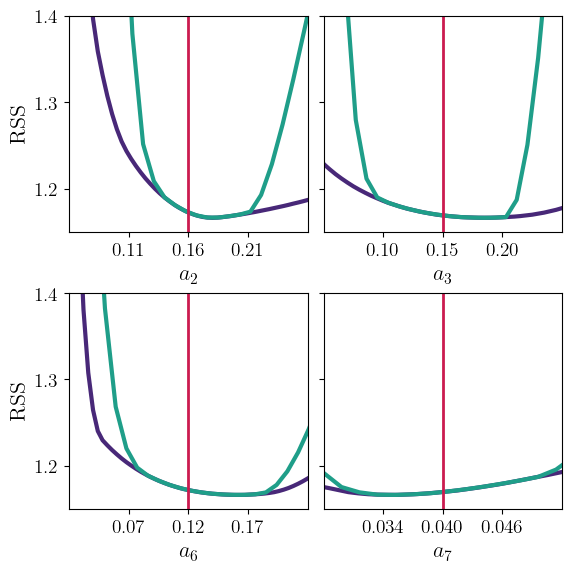

In [62]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), sharey=True)

axs[0,0].plot(df_a2_qt['$a_2$'], df_a2_qt['RSS'], lw=3, color=palette[0])
axs[0,0].plot(df_a2_ql_X3['$a_2$'], df_a2_ql_X3['RSS'], lw=3, color=palette[4])
axs[0,0].vlines(dfGroundPars['$a_2$'], ymin=0.0, ymax=2.0, colors=palette2[1], lw=2)
axs[0,0].set_xlabel('$a_2$')
axs[0,0].set_xlim((0.06, 0.26))
axs[0,0].set_xticks([0.11, 0.16, 0.21])

axs[0,1].plot(df_a3_qt['$a_3$'], df_a3_qt['RSS'], lw=3, color=palette[0])
axs[0,1].plot(df_a3_ql_X3['$a_3$'], df_a3_ql_X3['RSS'], lw=3, color=palette[4])
axs[0,1].vlines(dfGroundPars['$a_3$'], ymin=1.0, ymax=2.0, colors=palette2[1], lw=2)
axs[0,1].set_xlabel('$a_3$')
axs[0,1].set_xlim((0.05, 0.25))
axs[0,1].set_xticks([0.10, 0.15, 0.20])

axs[1,0].plot(df_a6_qt['$a_6$'], df_a6_qt['RSS'], lw=3, color=palette[0])
axs[1,0].plot(df_a6_ql_X3['$a_6$'], df_a6_ql_X3['RSS'], lw=3, color=palette[4])
axs[1,0].vlines(dfGroundPars['$a_6$'], ymin=1.0, ymax=2.0, colors=palette2[1], lw=2)
axs[1,0].set_xlabel('$a_6$')
axs[1,0].set_xlim((0.02, 0.22))
axs[1,0].set_xticks([0.07, 0.12, 0.17])

axs[1,1].plot(df_a7_qt['$a_7$'], df_a7_qt['RSS'], lw=3, color=palette[0])
axs[1,1].plot(df_a7_ql_X3['$a_7$'], df_a7_ql_X3['RSS'], lw=3, color=palette[4])
axs[1,1].vlines(dfGroundPars['$a_7$'], ymin=1.0, ymax=2.0, colors=palette2[1], lw=2)
axs[1,1].set_xlabel('$a_7$')
axs[1,1].set_xlim((0.028, 0.052))
axs[1,1].set_xticks([0.034, 0.040, 0.046])

# axs[1,1].plot(df_a1_qt['$a_1$'], df_a1_qt['RSS'], lw=3, color=palette[0])
# axs[1,1].plot(df_a1_ql_X3['$a_1$'], df_a1_ql_X3['RSS'], lw=3, color=palette[4])
# axs[1,1].vlines(dfGroundPars['$a_1$'], ymin=0.0, ymax=2.0, colors=palette2[1], lw=2)
# axs[1,1].set_xlabel('$a_1$')
# axs[1,1].set_xlim((0.055,0.305))

for i in range(2):
    axs[i,0].set_ylabel('RSS')
    axs[i,0].set_yticks([1.2, 1.3, 1.4])

# axs[0,0].text(0.81, 0.97, r'\textbf{b)}', transform=axs[0,0].transAxes, fontsize=22, va='top', ha='left')
# axs[0,1].text(0.81, 0.97, r'\textbf{c)}', transform=axs[0,1].transAxes, fontsize=22, va='top', ha='left')
# axs[1,0].text(0.81, 0.97, r'\textbf{d)}', transform=axs[1,0].transAxes, fontsize=22, va='top', ha='left')
# axs[1,1].text(0.81, 0.97, r'\textbf{e)}', transform=axs[1,1].transAxes, fontsize=22, va='top', ha='left')

# axs[0,0].set_title(r'\textbf{(b)}', loc='right')
# axs[0,1].set_title(r'\textbf{(c)}', loc='right')
# axs[1,0].set_title(r'\textbf{(d)}', loc='right')
# axs[1,1].set_title(r'\textbf{(e)}', loc='right')

plt.setp(axs, ylim=(1.15, 1.4))

# for i in range(2):
#     for j in range(2):
#         axs[i,j].set_yticks(np.arange(1.2, 1.5, step=0.1))

plt.tight_layout(w_pad=0.5, h_pad=0.1)

# fig.delaxes(axs[1,1])

plt.savefig("cycleLV_like_sel.svg", transparent=True)

plt.show()

In [161]:
mask = ~dfParams_all['Strategy'].isin(['II'])
mask &= ~dfParams_all['Parameters'].isin(['$a_1$', '$a_4$', '$a_5$', '$a_8$', '$a_9$'])
# mask &= ~dfParams_all['Parameters'].isin(['$a_1$', '$a_4$', '$a_5$', '$a_7$', '$a_8$', '$a_9$'])
dfParamSel = dfParams_all[mask].copy()

mask = ~dfParams_ground['Parameters'].isin(['$a_1$', '$a_4$', '$a_5$', '$a_8$', '$a_9$'])
# mask = ~dfParams_ground['Parameters'].isin(['$a_1$', '$a_4$', '$a_5$', '$a_7$', '$a_8$', '$a_9$'])
dfGroundSel = dfParams_ground[mask].copy()

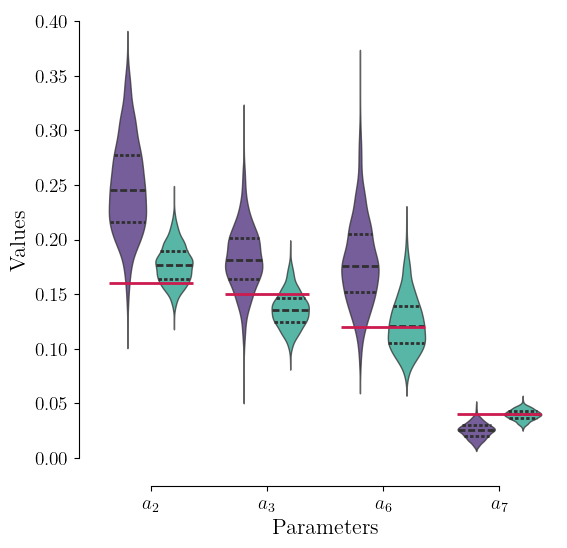

In [183]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6), facecolor='white')

colors = [palette[0], palette[4]]

axs = sns.violinplot(data=dfParamSel, x='Parameters', y='Values', hue='Strategy',
               palette=colors, alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

sns.pointplot(data=dfGroundSel, x='Parameters', y='Values', #label='Ground truth',
              color=palette2[1], linestyle="none", marker="_", markersize=60, markeredgewidth=2)

# axs.text(-0.01, 0.95, r'\textbf{(a)}', transform=axs.transAxes, fontsize=22, va='top', ha='left')
plt.legend([],[], frameon=False)

# axs.set_ylim((0.05,0.45))
sns.despine(offset=10, trim=True);

plt.savefig("cycleLV_boots_sel.svg", transparent=True)

plt.show()